# Compare SpecletTwo models with and without a *KRAS* allele covariate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [36]:
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io.cache_io import default_cache_dir
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models.speclet_two import SpecletTwo
from src.plot.color_pal import ModelColors, SeabornColor

In [33]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 248
np.random.seed(RANDOM_SEED)

## Load models

**Note:** I have changed the structure for caching in the pipeline, so if the following does not work, check that underlying structure and compare to that used here.

In [11]:
sp2 = SpecletTwo(
    "SpecletTwo-debug",
    root_cache_dir=default_cache_dir() / "SpecletTwo-debug",
    debug=True,
    kras_cov=False,
)
sp2_kras = SpecletTwo(
    "SpecletTwo-kras-debug",
    root_cache_dir=default_cache_dir() / "SpecletTwo-kras-debug",
    debug=True,
    kras_cov=True,
)

In [14]:
for s in [sp2, sp2_kras]:
    if s.cache_manager.advi_cache_exists():
        s.build_model()
        s.advi_sample_model()

[04/29/21 14:56:16] INFO     Calling                        speclet_model.py:155
                             `model_specification()`                            
                             method.                                            
                    INFO     Beginning PyMC3 model             speclet_two.py:75
                             specification.                                     
[04/29/21 14:56:17] WARNING  Dropping data points of  model_data_managers.py:125
                             sgRNA that map to                                  
                             multiple genes.                                    
                    WARNING  Dropping data points     model_data_managers.py:131
                             with missing copy                                  
                             number.                                            
                    INFO     Getting Theano shared variables.  speclet_two.py:82
                    INFO    

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


[04/29/21 14:56:58] INFO     Returning results from cache.  speclet_model.py:377


/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


[04/29/21 14:57:05] INFO     Calling                        speclet_model.py:155
                             `model_specification()`                            
                             method.                                            
                    INFO     Beginning PyMC3 model             speclet_two.py:75
                             specification.                                     
                    INFO     Getting Theano shared variables.  speclet_two.py:82
                    INFO     Creating PyMC3 model.             speclet_two.py:90
[04/29/21 14:57:06] INFO     Returning results from cache.  speclet_model.py:377


/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


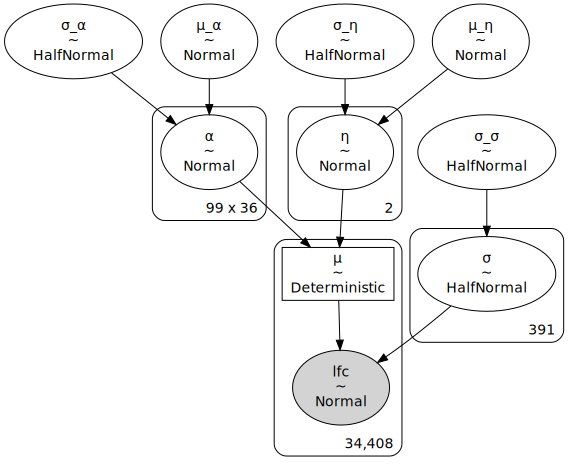

In [20]:
pm.model_to_graphviz(sp2.model)

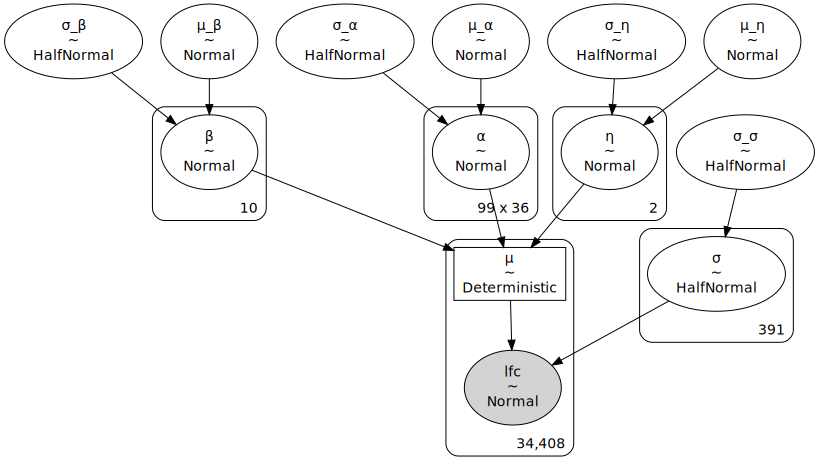

In [21]:
pm.model_to_graphviz(sp2_kras.model)

In [32]:
az_sp2 = pmapi.convert_samples_to_arviz(sp2.model, sp2.advi_results)
az_sp2_kras = pmapi.convert_samples_to_arviz(sp2_kras.model, sp2_kras.advi_results)

## ADVI diagnositics

Can probably re-run with the max number of iterations at 30,000.

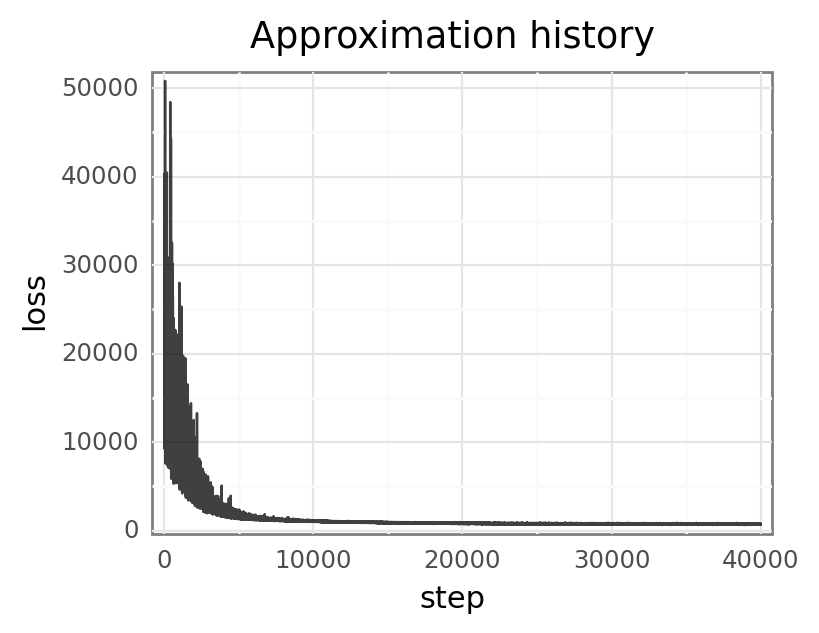

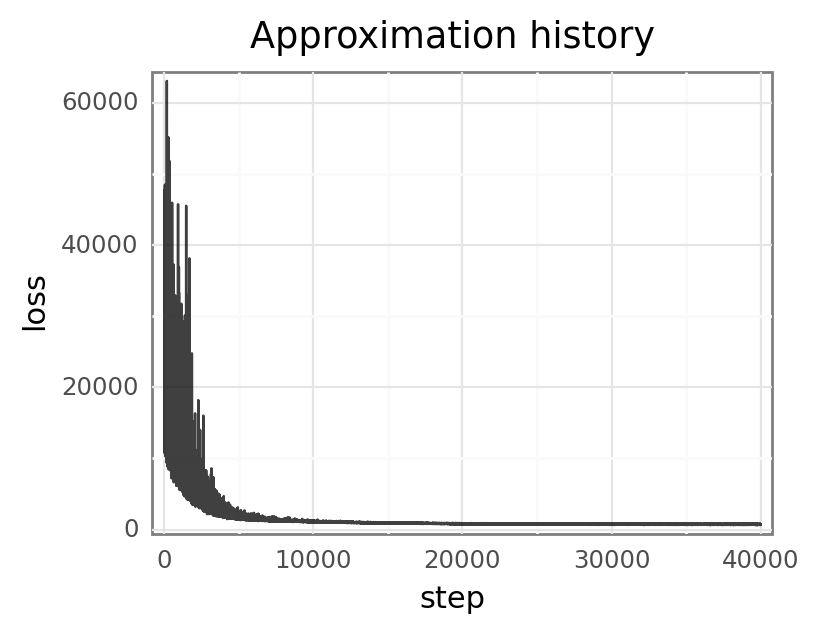

In [31]:
for sp in [sp2, sp2_kras]:
    p = pmanal.plot_vi_hist(sp.advi_results.approximation) + gg.theme(
        figure_size=(4, 3)
    )
    print(p)

## Compare models

### Parameter estimates

In [46]:
(
    sp2_kras.data_manager.get_data()[["kras_mutation", "depmap_id"]]
    .drop_duplicates()
    .groupby("kras_mutation")
    .count()
    .sort_values("depmap_id")
)

,depmap_id
kras_mutation,
Q61H,1
other,1
Q61L,1
A146V,1
G12A,1
G12C,2
G13D,3
G12V,3
G12D,5


In [38]:
kras_posterior = az.summary(
    az_sp2_kras, var_names="β", hdi_prob=PYMC3.HDI_PROB, kind="stats"
)
kras_posterior[
    "kras_mutation"
] = sp2_kras.data_manager.get_data().kras_mutation.cat.categories
kras_posterior

,mean,sd,hdi_5.5%,hdi_94.5%,kras_mutation
β[0],-0.037,0.009,-0.053,-0.024,G12D
β[1],-0.009,0.004,-0.016,-0.002,WT
β[2],-0.132,0.033,-0.180,-0.076,Q61H
β[3],-0.016,0.010,-0.029,0.001,G13D
β[4],-0.059,0.012,-0.080,-0.041,G12C
β[5],-0.009,0.011,-0.026,0.007,G12V
β[6],-0.057,0.017,-0.088,-0.034,other
β[7],-0.203,0.037,-0.259,-0.143,Q61L
β[8],0.046,0.018,0.017,0.075,A146V
β[9],-0.145,0.024,-0.183,-0.107,G12A


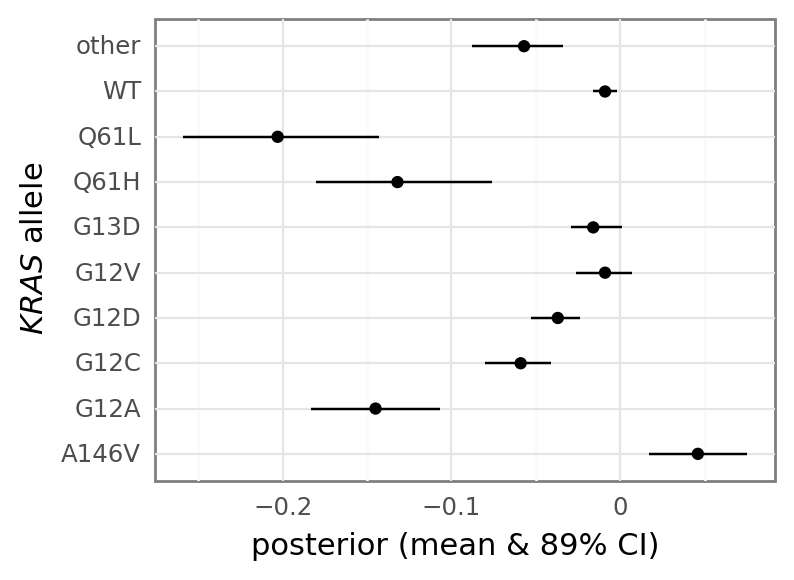

<ggplot: (8729825443069)>

In [43]:
(
    gg.ggplot(kras_posterior, gg.aes(x="kras_mutation", y="mean"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"))
    + gg.geom_point()
    + gg.coord_flip()
    + gg.theme(figure_size=(4, 3))
    + gg.labs(x="$KRAS$ allele", y="posterior (mean & 89% CI)")
)

### Prediction accuracy

### Model fit

---

In [5]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.00 minutes


In [6]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-04-29

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-231.o2.rc.hms.harvard.edu

Git branch: optional-kras-cov

plotnine  : 0.8.0
numpy     : 1.20.2
theano    : 1.0.5
pandas    : 1.2.3
pymc3     : 3.11.2
re        : 2.2.1
matplotlib: 3.4.1
seaborn   : 0.11.1
arviz     : 0.11.2

